# Problem Description
The goal of this notebook is to build an Unsupervised learning model for predicting diabetes. It aims to classify individuals into clusters based on their health characteristics which includes but not limited to physical fitness, dietary habits, and lifestyle choices.

## Data
The data is sourced from https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators.

See https://www.cdc.gov/brfss/annual_data/annual_2014.html as well for more information about codes.

## Importing libraries

In [2]:
import numpy as np
import pandas as pd
import re
import string
from collections import  Counter
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline


In [3]:
# Load data
df = pd.read_csv("data/diabetes_binary_health_indicators_BRFSS2015.csv")

### Exploratory Data Analysis

In [4]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [7]:
# Check for missing data
df.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Splitting people who do have diabetes and those who don"t for ease.

In [9]:
df_yes_diabetes = df[df["Diabetes_binary"] == 1]
df_no_diabetes = df[df["Diabetes_binary"] == 0]

In [ ]:
import random
# For more colorful displays
seaborn_palettes = [
    "deep", "muted", "bright", "pastel", "dark", "colorblind",
    "husl", "hls", "cool", "hot", "spring", "summer", "autumn", "winter",
    "Blues", "BrBG", "BuGn", "BuPu", "CMRmap", "GnBu", "Greens", "Greys",
    "OrRd", "Oranges", "PRGn", "PiYG", "PuBu", "PuBuGn", "PuOr", "PuRd",
    "Purples", "RdBu", "RdGy", "RdPu", "RdYlBu", "RdYlGn", "Reds", "Spectral",
    "Wistia", "YlGn", "YlGnBu", "YlOrBr", "YlOrRd"
]
def countplot_feature_by_diabetes(feature):
    """
    Helper to plot a countplot feature by diabetes
    """
    ax = sns.countplot(df, x="Diabetes_binary", hue=feature, palette=seaborn_palettes[random.randint(0, len(seaborn_palettes)-1)])
    ax.set(title=f"Diabetes status by {feature}", xlabel="Diabetes Status", ylabel="Count")
    ax.set_xticks(ax.get_xticks())
    ax.xaxis.set_ticklabels(["No Diabetes", "Has Diabetes"])
    ax.legend(title=feature)
    return ax

In [74]:
df_yes_diabetes["Age"]

8          9.0
10        13.0
13        11.0
17         7.0
23        13.0
          ... 
253659     6.0
253668    10.0
253670    13.0
253676    11.0
253679     9.0
Name: Age, Length: 35346, dtype: float64

### Age

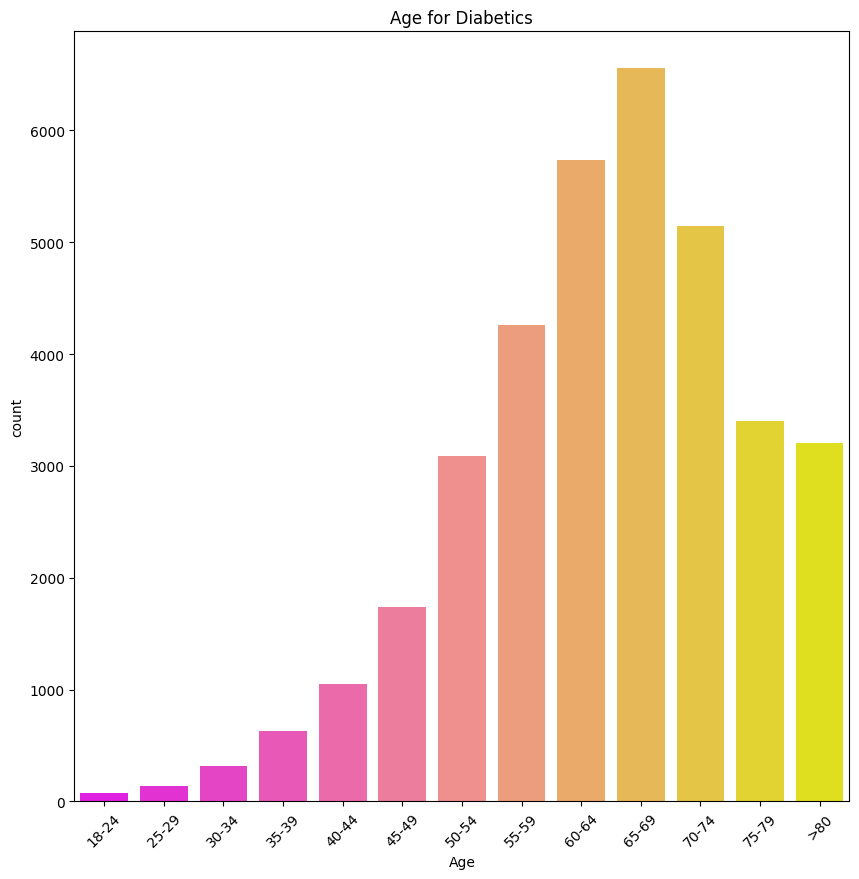

In [86]:
fig = plt.figure(figsize=(10,10))
ax = sns.countplot(df_yes_diabetes, x="Age", hue="Age", legend=False,palette="spring")
ax.set(title="Age for Diabetics")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", ">80"], rotation = 45)
plt.show()

### BMI

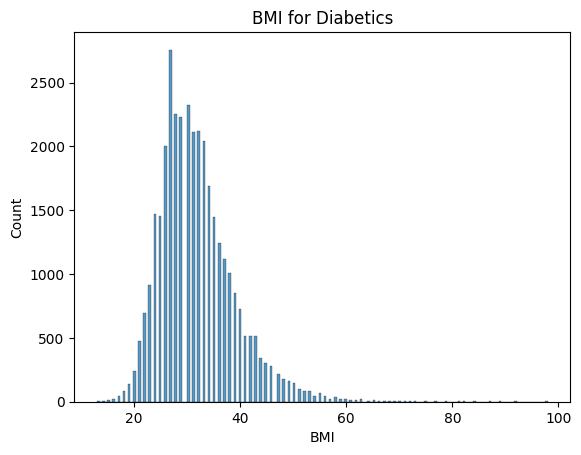

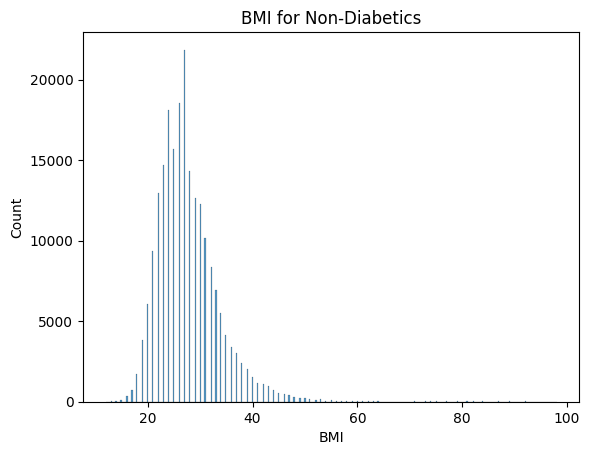

In [92]:
sns.histplot(df_yes_diabetes, x="BMI").set(title="BMI for Diabetics")
plt.show()

sns.histplot(df_no_diabetes, x="BMI").set(title="BMI for Non-Diabetics")
plt.show()

### Income

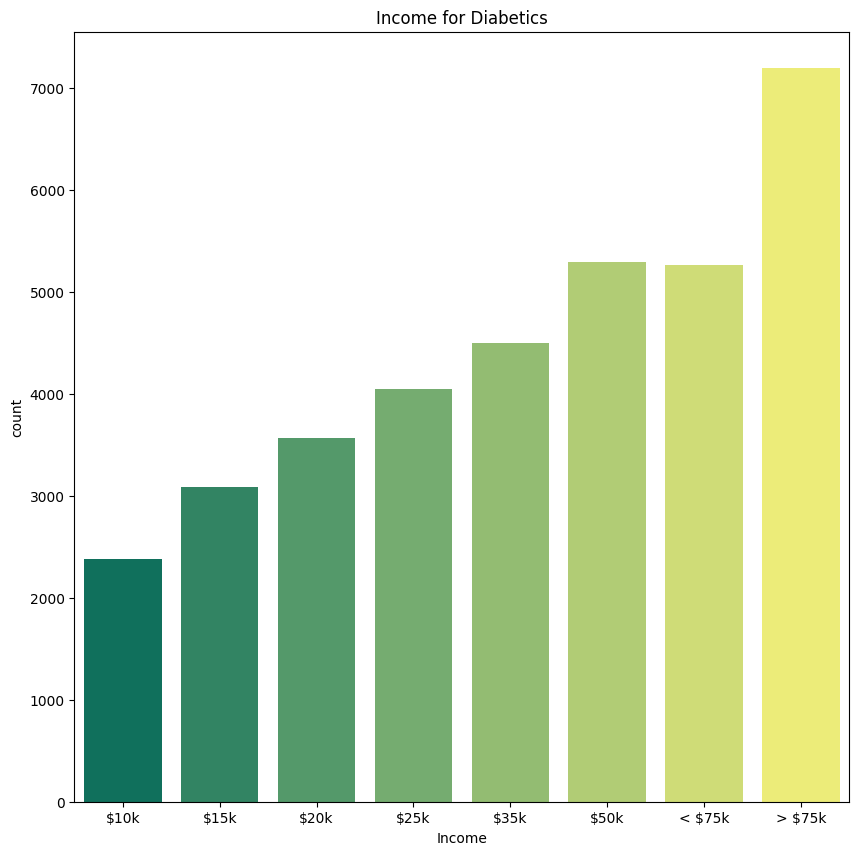

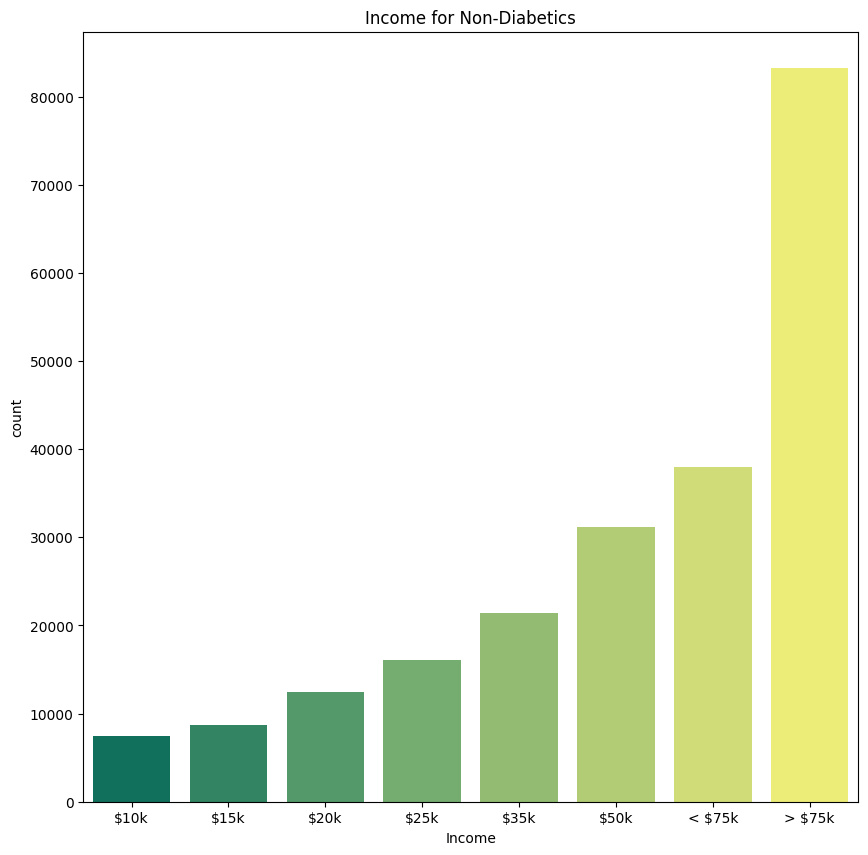

In [93]:
fig = plt.figure(figsize=(10,10))
ax = sns.countplot(df_yes_diabetes, x="Income", hue="Income", legend=False,palette="summer")
ax.set(title="Income for Diabetics")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["$10k", "$15k", "$20k", "$25k", "$35k", "$50k", "< $75k", "> $75k"])
plt.show()

fig = plt.figure(figsize=(10,10))
ax = sns.countplot(df_no_diabetes, x="Income", hue="Income", legend=False,palette="summer")
ax.set(title="Income for Non-Diabetics")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["$10k", "$15k", "$20k", "$25k", "$35k", "$50k", "< $75k", "> $75k"])
plt.show()

### Gender

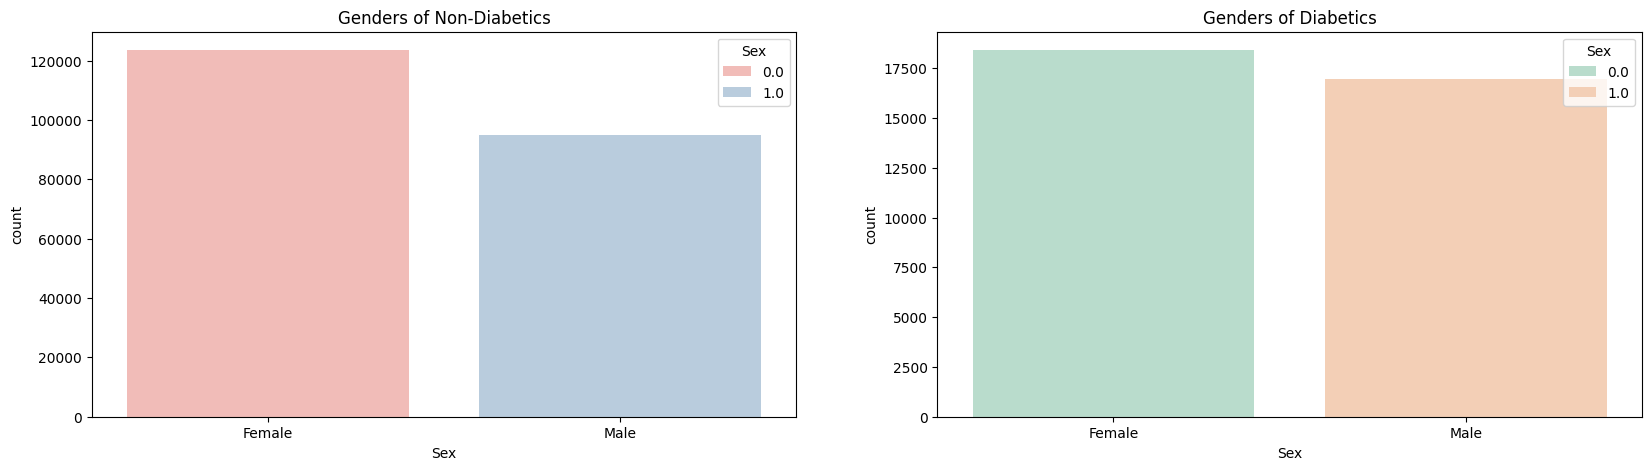

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1 = sns.countplot(df_no_diabetes, x="Sex", ax=ax1, hue="Sex", palette="Pastel1")
ax1.set(title="Genders of Non-Diabetics")
ax1.set_xticks(ax1.get_xticks())
ax1.xaxis.set_ticklabels(["Female", "Male"])

ax2 = sns.countplot(df_yes_diabetes, x="Sex", ax=ax2, hue="Sex", palette="Pastel2")
ax2.set(title="Genders of Diabetics")
ax2.set_xticks(ax2.get_xticks())
ax2.xaxis.set_ticklabels(["Female", "Male"])
plt.show()

### Other Features Plotted

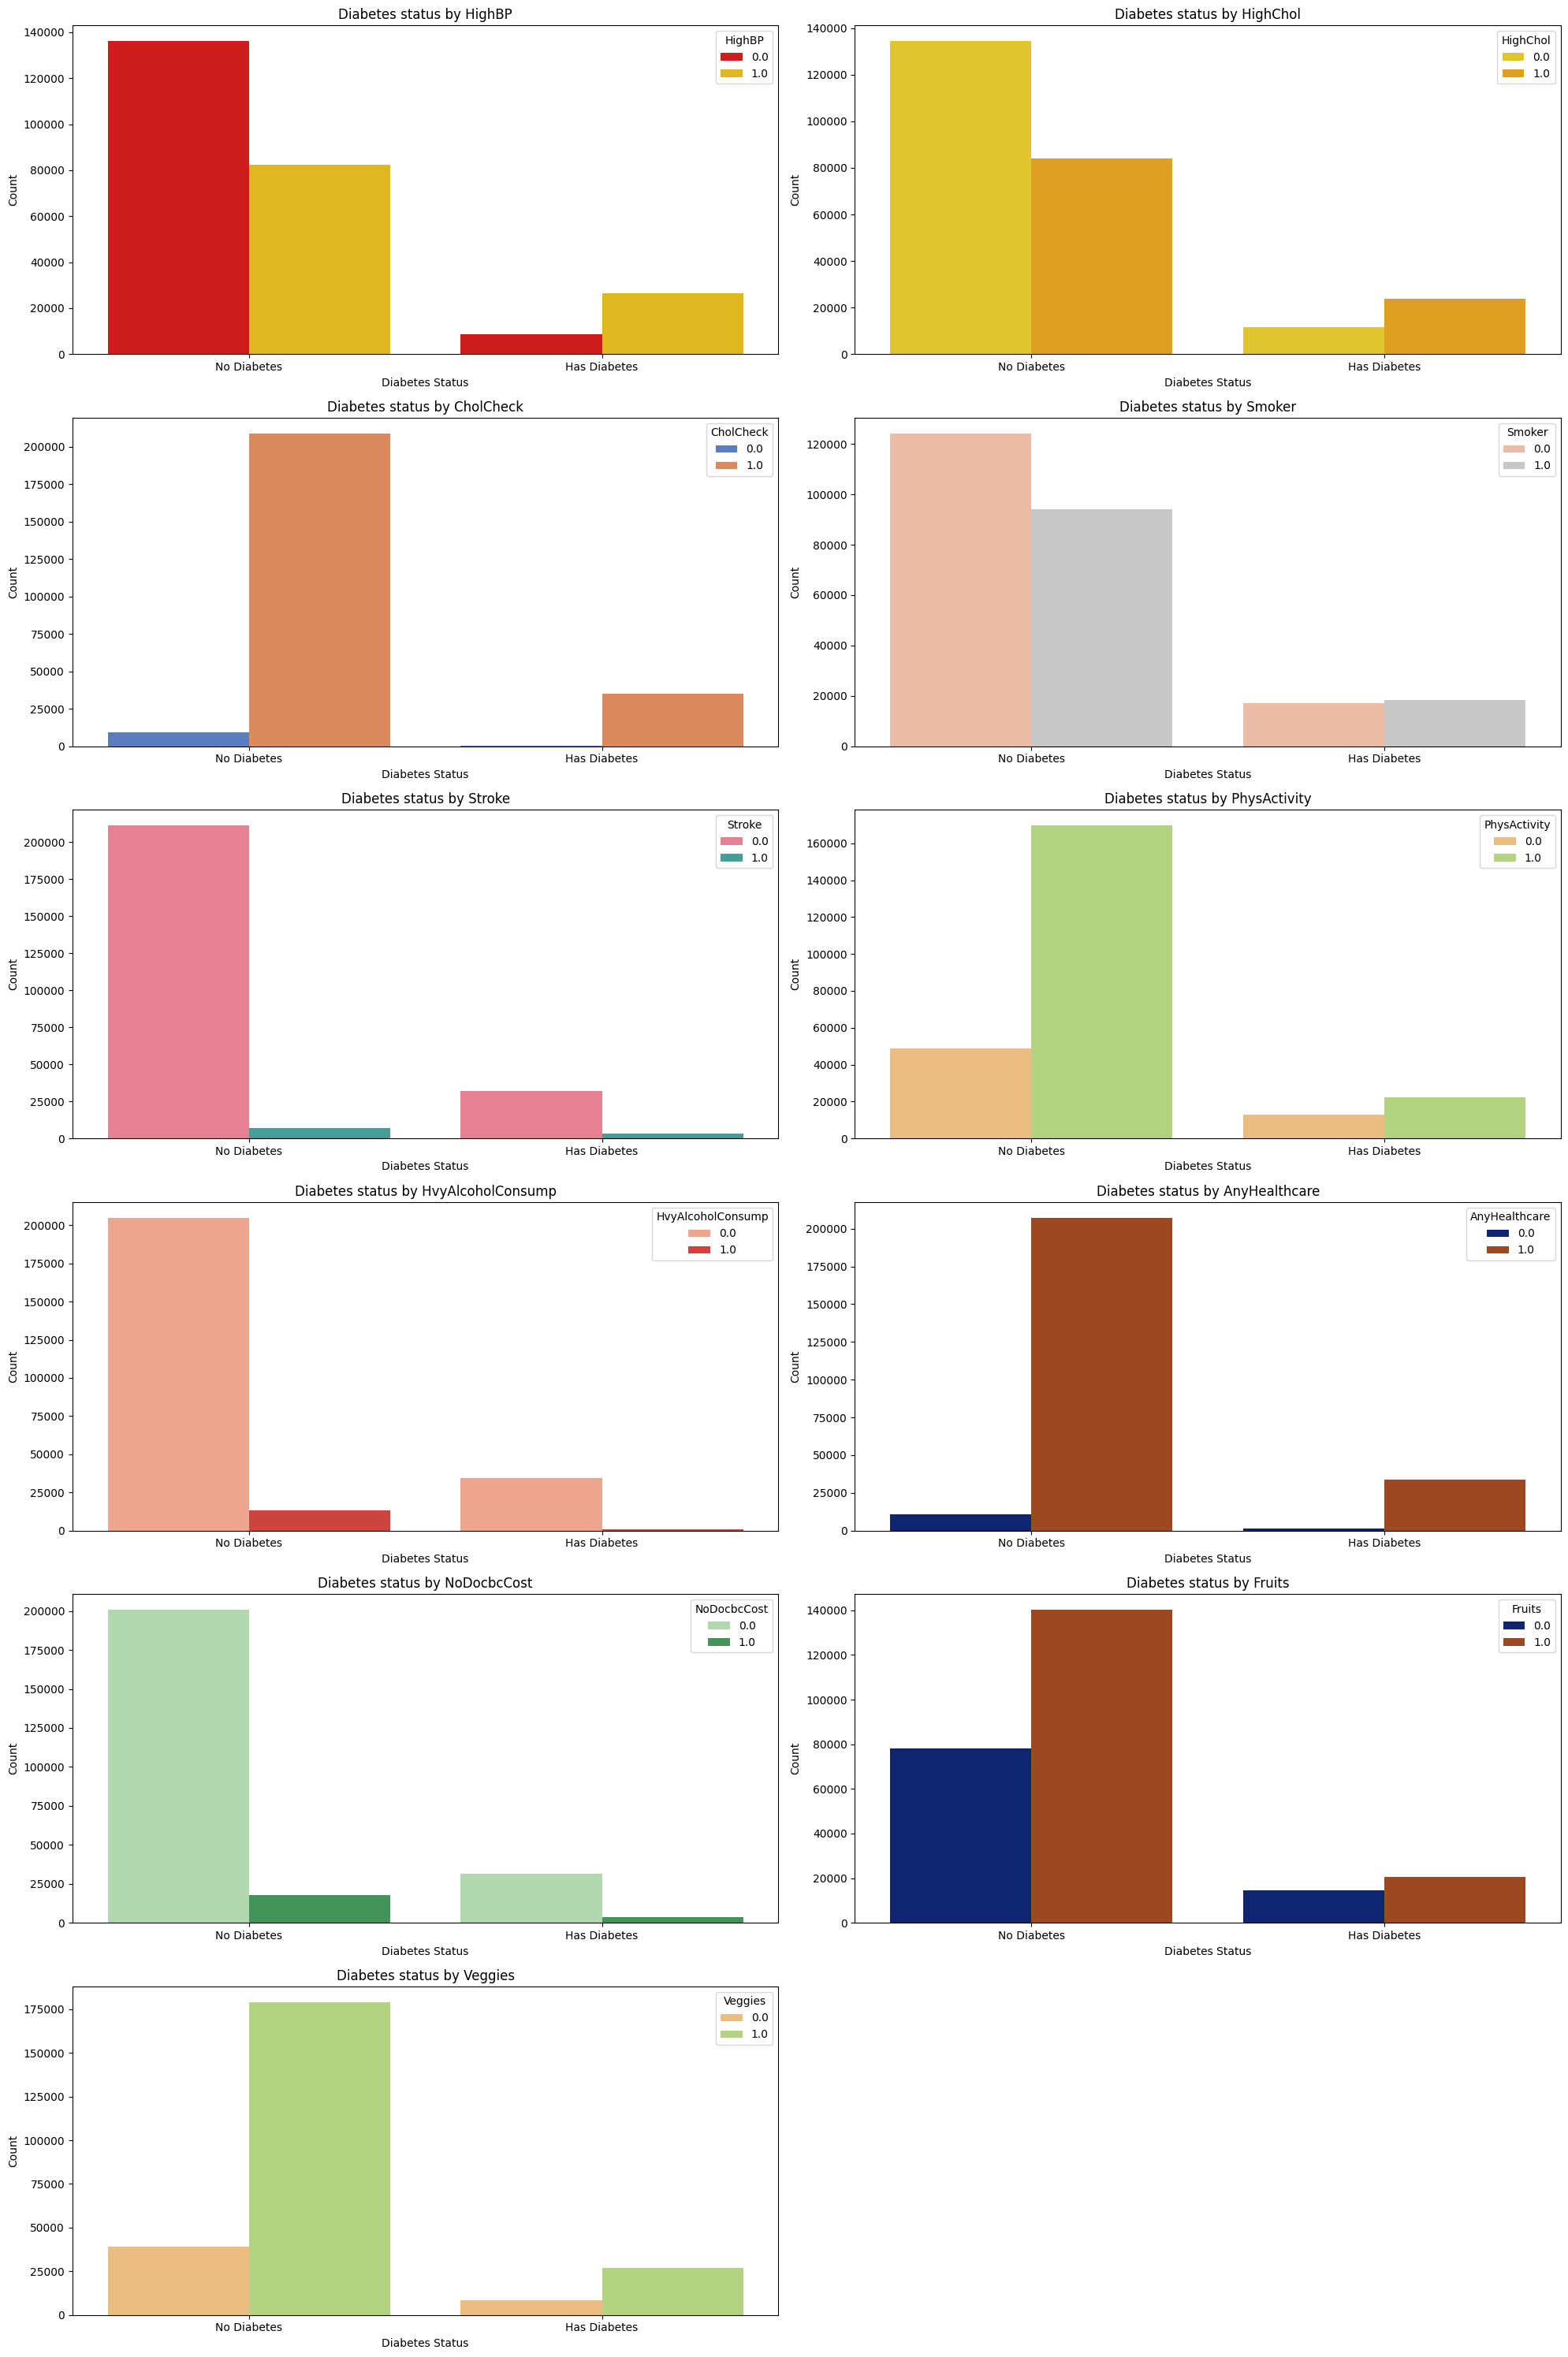

In [72]:
other_features = ["HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", "PhysActivity", "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", "Fruits", "Veggies"]
# for better display
rows = 6
cols = 2
c = 1
fig = plt.figure(figsize=(20, 30))
for feature in other_features:
    plt.subplot(rows, cols, c)
    ax = countplot_feature_by_diabetes(feature)
    c += 1
plt.tight_layout()
plt.show()

## Correlation Matrix

<Axes: >

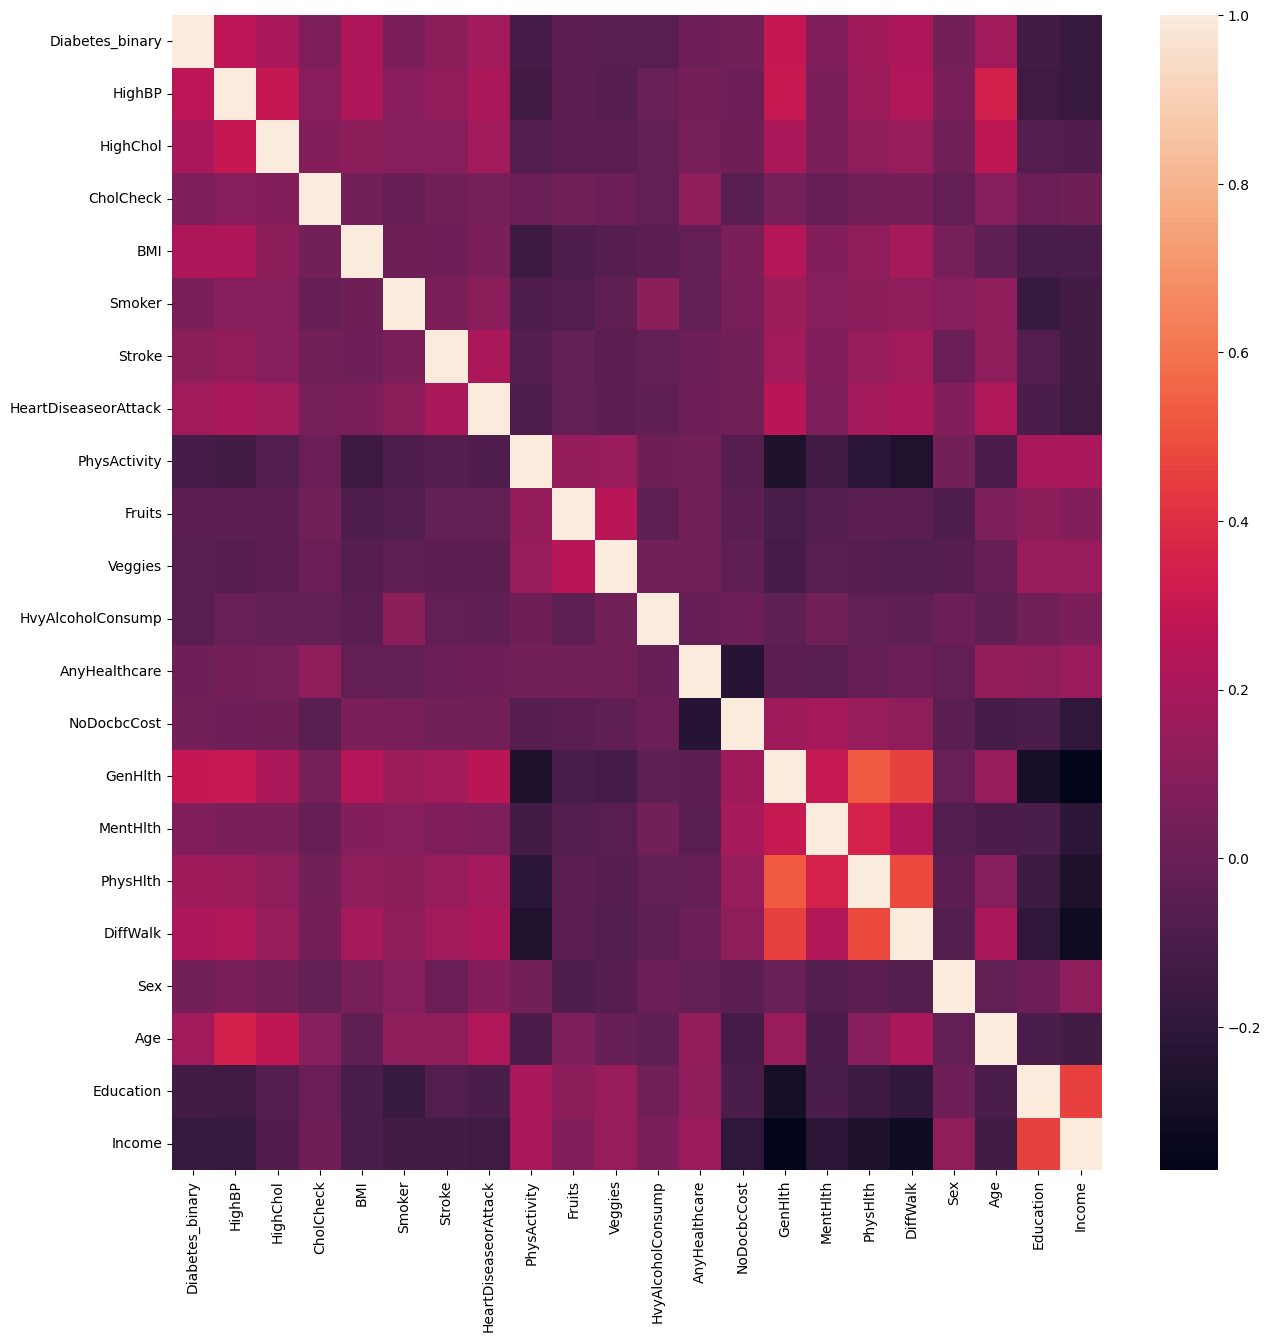

In [91]:
correlation = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(data=correlation)

### Analysis

- Diabetics are mostly from 50+ years old.
- Diabetics generally have a higher BMI.
- Diabetics have higher blood pressure and cholesterol.
- Smoking appears to have little to no affect on diabetes status.
- Diabetics tend to never have a stroke.
- Physical activity seems to have no affect on diabetes.
- Heavy alcohol consumption has no affect on diabetes.
- Eating fruits and veggies or not having a doctor doesn't seem to correlate with having diabetes.
- Common health issues seem to be heavy correlated to having diabetes.